In [1]:
import os
import numpy as np

import tarfile
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets.utils import download_url, extract_archive

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

In [2]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = get_default_device()

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [3]:
device

device(type='cuda')

In [4]:
project_name = 'cifar10_resnet'

In [5]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

100%|██████████| 135M/135M [00:02<00:00, 51.0MB/s]


In [6]:
with tarfile.open('cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [7]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))

['train', 'test']


In [8]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats, inplace=True)])

valid_tfms = tt.Compose([tt.ToTensor(),
                         tt.Normalize(*stats)])

In [9]:
train_ds = ImageFolder(data_dir + '/train', transform=train_tfms)
valid_ds = ImageFolder(data_dir + '/test', transform=valid_tfms)

In [10]:
classes = train_ds.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [11]:
batch_size = 420

In [12]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [13]:
def denormalize(img, means, stds):
    means = torch.tensor(means).view(1, 3, 1, 1)
    stds = torch.tensor(stds).view(1, 3, 1, 1)
    return img * stds + means

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_imgs = denormalize(images, *stats)
        img = make_grid(denorm_imgs[:64], nrow=8)
        ax.imshow(img.permute(1, 2, 0).clamp(0, 1))
        break

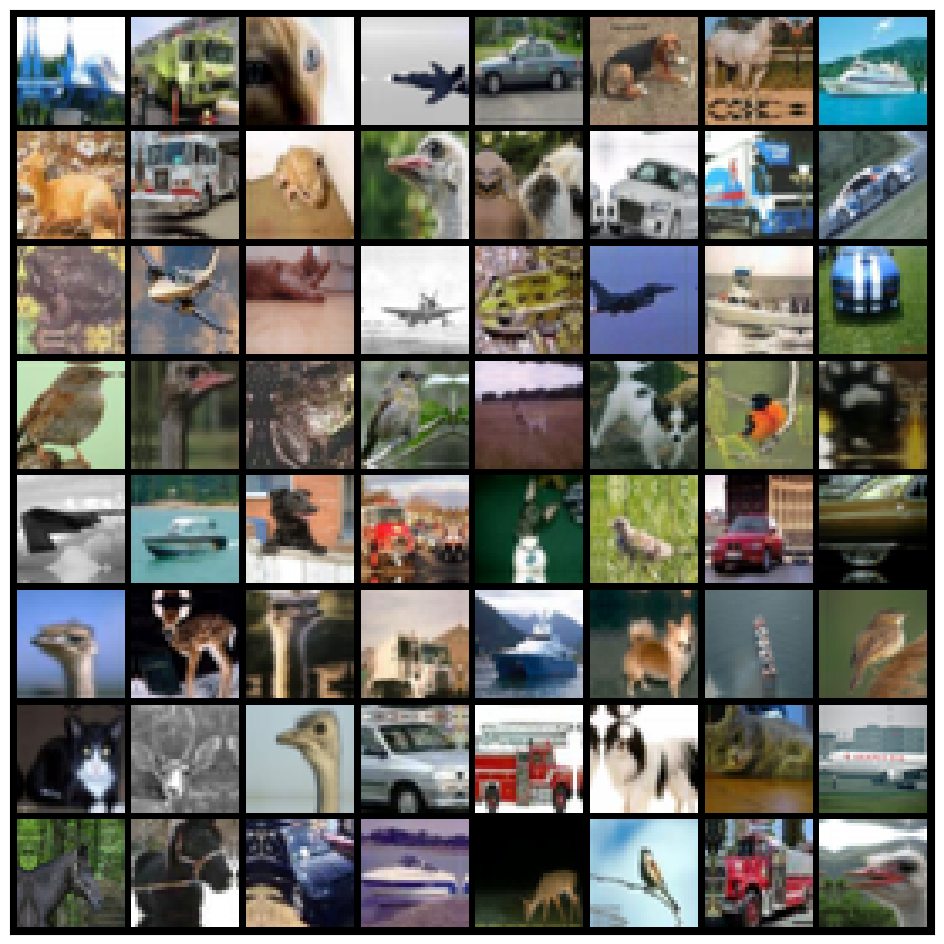

In [15]:
show_batch(train_dl)

In [16]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [17]:
class ResidualBlock(nn.Module):
    def __init__ (self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out += identity
        return out

In [18]:
resnet = to_device(ResidualBlock(), device)

for images, labels in train_dl:
    out = resnet(images)
    print(out.shape)
    break

torch.Size([420, 3, 32, 32])


In [19]:
del resnet, images, labels
torch.cuda.empty_cache()

In [20]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f'Epoch [{epoch}], last_lr: {result["lrs"][-1]}, train_loss:{result["train_loss"]:.4f}, val_loss: {result["val_loss"]:.4f}, val_acc: {result["val_acc"]:.4f}')

In [22]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [23]:
class ResNet9(ImageClassification):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(
            conv_block(128, 128),
            conv_block(128, 128)
        )
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(
            conv_block(512, 512),
            conv_block(512, 512)
        )
        self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                        nn.Flatten(),
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [24]:
model = to_device(ResNet9(3, len(classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [25]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_one_cycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0, grad_clip=None, opt_func=optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        torch.cuda.empty_cache()
        model.train()
        train_losses = []
        lrs = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [26]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.3033480644226074, 'val_acc': 0.10287698358297348}]

In [27]:
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = optim.Adam

In [28]:
%%time
history += train_one_cycle(epochs, max_lr, model, train_dl, valid_dl, weight_decay=weight_decay, grad_clip=grad_clip, opt_func=opt_func)

Epoch [0], last_lr: 0.003928088789456022, train_loss:1.5059, val_loss: 1.8223, val_acc: 0.4752
Epoch [1], last_lr: 0.00935253649633302, train_loss:1.1114, val_loss: 3.1868, val_acc: 0.3453
Epoch [2], last_lr: 0.009719417773875232, train_loss:0.9664, val_loss: 1.4779, val_acc: 0.6232
Epoch [3], last_lr: 0.008117456539497631, train_loss:0.6959, val_loss: 0.8194, val_acc: 0.7147
Epoch [4], last_lr: 0.005559840141227017, train_loss:0.5613, val_loss: 0.5386, val_acc: 0.8136
Epoch [5], last_lr: 0.0028306099820869924, train_loss:0.4386, val_loss: 0.4376, val_acc: 0.8514
Epoch [6], last_lr: 0.0007664159383425639, train_loss:0.3534, val_loss: 0.3564, val_acc: 0.8749
Epoch [7], last_lr: 4e-08, train_loss:0.2678, val_loss: 0.3207, val_acc: 0.8916
CPU times: user 19.3 s, sys: 3.7 s, total: 23 s
Wall time: 4min 28s


In [29]:
train_time = '4:28'

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-o')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Validation Accuracy vs Epochs (Optimizer: {opt_func})')
    plt.grid()
    plt.show()

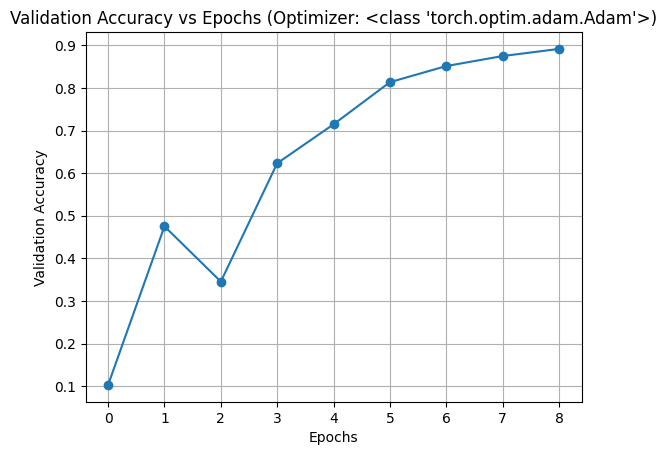

In [31]:
plot_accuracies(history)

In [40]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx', label='Train Loss')
    plt.plot(val_losses, '-rx', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Epochs (Optimizer: {opt_func})')
    plt.legend(['Train Loss', 'Validation Loss'])
    plt.grid()
    plt.show()

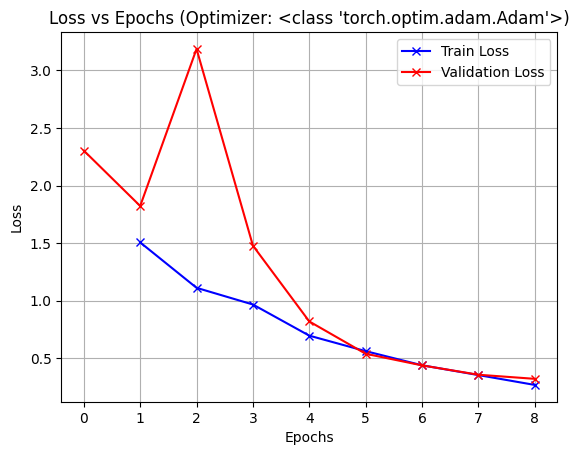

In [41]:
plot_losses(history)

In [42]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch No.')
    plt.ylabel('Learning Rate')

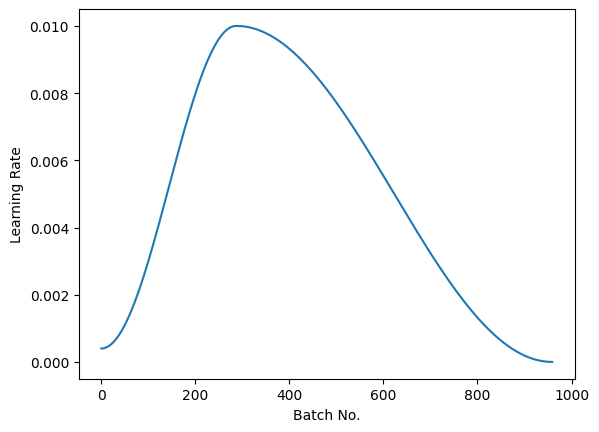

In [43]:
plot_lrs(history)

In [45]:
def predict_image(image, model):
  xb = to_device(image.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return classes[preds[0].item()]

Text(0.5, 1.0, 'Label:, airplane, , Predicted:, airplane')

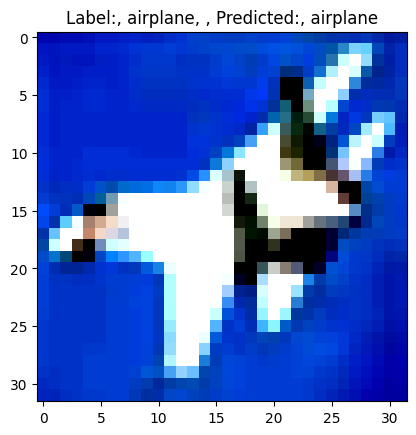

In [49]:
img, label = valid_ds[1]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.title(f'Label:, {classes[label]}, , Predicted:, {predict_image(img, model)}')

Text(0.5, 1.0, 'Label:, automobile, , Predicted:, automobile')

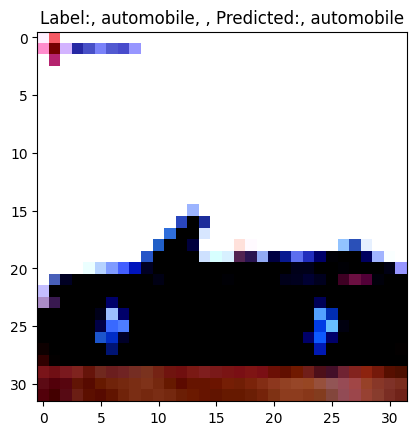

In [50]:
img, label = valid_ds[1024]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
plt.title(f'Label:, {classes[label]}, , Predicted:, {predict_image(img, model)}')

In [51]:
torch.save(model.state_dict(), f'{project_name}.pth')